# U-net Denoising demo

In [1]:
# libs
from scipy.io import wavfile
from scipy import signal
from time import time
import random
import librosa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

## Steps
- 1. Load the data
- - Have the PASCAL clean data ready, and the ARCA23K synthetic data as well
- - Also load the HAN dataset from the Ali paper
- 2. Normalization steps for the data
- - Apply LPF/BPF and do resampling. All sounds should be at a standard frequency
- 3. Create the synthetic noise composites (and keep track of their noiseless counterparts)
- - Do visualizations (qualitative analysis here. You'll do this again at the end as PoC)
- 4. (Legacy) Run the STFT on both to create your inputs and outputs for the model
- 5. Segment the synthetic noise composites to create training and test data
- 6. Design the LU-Net
- 7. Train the LU-Net
- 8. Visualize resutls
- 9. Quantify the improvement in terms of SNR or similar


In [2]:
## Dirs
# the circor digiscope phonocardiogram dataset
pcg_datapath = '/Users/donu/Desktop/S25/ELEC 594/datasets/the-circor-digiscope-phonocardiogram-dataset-1.0.3/'
# the bentley dataset is the clean PCG dataset from the U-net paper
pascal_dset_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/pascal-dset/'

In [74]:
arcalabels_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_ground_truth/'
# the arcawavs directory contains the real world noise data from the ARCA23K dataset
arcawavs_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/'
# hospital ambient sounds dataset, from the Ali paper
han_raw_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/'
han_filtered_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-filtered-resampled/'

## 1. Loading the data

### 1.a Exploring PCG data

In [3]:
# Exploring the PCG data
pcg_data = pd.read_csv(pcg_datapath+'training_data.csv')

In [4]:
pcg_data.shape

(942, 23)

In [5]:
pcg_data.columns

Index(['Patient ID', 'Recording locations:', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Outcome', 'Campaign', 'Additional ID'],
      dtype='object')

In [6]:
pcg_data['Murmur'].value_counts()

Murmur
Absent     695
Present    179
Unknown     68
Name: count, dtype: int64

In [7]:
pcg_data.loc[pcg_data['Murmur'].eq('Absent') | pcg_data['Murmur'].eq('Present')]

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,85340,AV+PV+TV+MV,Child,Male,105.0,16.6,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
938,85341,AV+PV+TV+MV,Child,Male,92.0,15.2,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
939,85343,AV+PV+TV+MV,Child,Female,97.0,13.5,False,Present,MV+TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
940,85345,AV+PV,Child,Female,132.0,38.1,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN


### 1.b Loading the PASCAL dataset

In [8]:
pcg_data = pd.read_csv(pascal_dset_path+'set_b.csv')

In [9]:
pcg_data['label'].value_counts()

label
normal        320
murmur         95
extrastole     46
Name: count, dtype: int64

In [10]:
# set aside extrastole for now
##cg_data = pcg_data.loc[pcg_data['label'].eq('normal') | pcg_data['label'].eq('murmur')]

### 1.b.1 - Clean up horrible data formatting (only run this once)

In [11]:
#for i in range(pcg_data.shape[0]):
##  # delete "Btraining"
##  #pcg_data.loc[i,'fname'] = 'setb/'+pcg_data.iloc[i,:]['fname'].split('/')[-1][10:]
#  filename = pcg_data.iloc[i,:]['fname'].split('/')[-1]
#  cut_idx = re.search(r'\d',filename).start()
#  pcg_data.loc[i,'fname'] = pcg_data.loc[i,'fname'].replace('setb','set_b')
#  pcg_data.loc[i,'fname'] = 'set_b/'+filename[cut_idx:]
#  

In [12]:
#pcg_data.to_csv(pascal_dset_path+'set_b.csv',index=False)

In [13]:
pcg_data['sublabel'].value_counts()

sublabel
noisynormal    120
noisymurmur     29
Name: count, dtype: int64

In [80]:
pcg_data = pcg_data.loc[(pcg_data['label'].eq('normal') |
                        pcg_data['label'].eq('murmur')) & 
                        pcg_data['sublabel'].ne('noisynormal') & 
                        pcg_data['sublabel'].ne('noisymurmur')]

In [81]:
pcg_data

,dataset,fname,label,sublabel
46,b,set_b/112_1306243000964_A.wav,murmur,NaN
47,b,set_b/112_1306243000964_B.wav,murmur,NaN
48,b,set_b/112_1306243000964_D.wav,murmur,NaN
49,b,set_b/116_1306258689913_A.wav,murmur,NaN
50,b,set_b/116_1306258689913_C.wav,murmur,NaN
...,...,...,...,...
307,b,set_b/296_1311682952647_A1.wav,normal,NaN
308,b,set_b/296_1311682952647_A2.wav,normal,NaN
309,b,set_b/298_1311685888900_B.wav,normal,NaN
310,b,set_b/299_1311770522820_C.wav,normal,NaN


In [16]:
pcg_data.shape # this does not contain noisy data
# it does not contain murmurs either. this may be hugely importnat
# !IMPT: does not contain unlabelled data (which is like 1/3rd of dataset)

(266, 4)

In [17]:
# write to csv
##pcg_data.to_csv(bentley_dset+'set_b.csv',index=False)

In [18]:
#for fname in os.listdir(bentley_dset+'set_b/'):
#  # renaming
#  cutidx = re.search(r'\d',fname).start()
#  os.rename(bentley_dset+'set_b/'+fname,bentley_dset+'set_b/'+fname[cutidx:])

### 1.b.2 - Find Corresponding wav for each label

In [19]:
times = []
sample_rates = []
wav_lengths = dict()
for idx, row in pcg_data.iterrows():
  filepath_local = row['fname']
  label = row['label']
  #wavfile.read(pascal_dset_path+filepath_local)[1]
  arr,sr = librosa.load(pascal_dset_path+filepath_local)
  length = len(arr)/sr
  
  wav_lengths[filepath_local] = length
  times.append(length) #time
  sample_rates.append(sr)
  
print(np.mean(times),np.min(times),np.max(times))
print(np.mean(sample_rates),np.min(sample_rates),np.max(sample_rates))
times.sort()
PCG_SAMPLE_RATE = np.min(sample_rates) # everything is 22050
print(times[len(times)//5]) # ~20th percentile is 2.06 seconds

CUTOFF_SECONDS = 2
CUTOFF = CUTOFF_SECONDS*PCG_SAMPLE_RATE # 2 seconds
# ok, i think for now we can toss out times below 2 seconds

5.159780744377952 0.763265306122449 24.16
22050.0 22050 22050
2.0630385487528344


In [53]:
len(wav_lengths)

266

In [21]:
# checkpoint 1. done so far:
## downlaoded the datasets (synthetic noise, circor, and bentley - the U-net one)
## renamed the horribly named files and .csv column values in the bentley dataset
# able to read the corresponding wavfile for each row in the bentley dataset (i.e. map murmurs to wav!)

In [22]:
#next
## add noise to each, remove noise. see if that's possible
# ok, let's only resample ambient noise.

### 1.c - Loading the ARCA23K real world noises

In [23]:
#os.listdir(arcawavs)
noise_data = pd.read_csv(arcalabels_path+'train.csv')

In [24]:
label_amnts = dict(noise_data['label'].value_counts())

for key in label_amnts.keys():
  print(key,label_amnts[key])

Wind_instrument_and_woodwind_instrument 2458
Bowed_string_instrument 1841
Piano 677
Snare_drum 631
Trumpet 504
Fart 464
Electric_guitar 399
Acoustic_guitar 355
Bark 340
Coin_(dropping) 333
Female_speech_and_woman_speaking 313
Male_speech_and_man_speaking 302
Clapping 289
Gunshot_and_gunfire 283
Walk_and_footsteps 275
Organ 266
Bass_guitar 259
Camera 254
Squeak 253
Train 245
Zipper_(clothing) 244
Thump_and_thud 239
Livestock_and_farm_animals_and_working_animals 238
Whoosh_and_swoosh_and_swish 225
Tearing 214
Writing 211
Cough 208
Wind 206
Slam 201
Scratching_(performance_technique) 199
Rattle_(instrument) 196
Run 192
Dishes_and_pots_and_pans 191
Splash_and_splatter 186
Burping_and_eructation 181
Gong 175
Screaming 173
Crash_cymbal 171
Crackle 170
Crumpling_and_crinkling 165
Knock 150
Harp 149
Chewing_and_mastication 146
Stream 138
Tap 138
Toilet_flush 137
Keys_jangling 131
Meow 130
Waves_and_surf 126
Child_speech_and_kid_speaking 124
Boom 122
Drill 117
Cricket 115
Finger_snapping 110
Ha

In [25]:
# things to look at:
## Child_speech_and_kid_speaking
## Male_speech_and_man_speaking
## Crumpling_and_crinkling
# Just do crumpling and crinkling for now. This is a demo

In [26]:
# this is now legacy, since all non-relevant labels have been removed
relevant_labels = noise_data.loc[noise_data['label'].eq('Crumpling_and_crinkling') 
                                | noise_data['label'].eq('Child_speech_and_kid_speaking') 
                                | noise_data['label'].eq('Male_speech_and_man_speaking')
                                | noise_data['label'].eq('Female_speech_and_woman_speaking')
                                | noise_data['label'].eq('Cough')
                                | noise_data['label'].eq('Squeak')
                                | noise_data['label'].eq('Walk_and_footsteps')
                                | noise_data['label'].eq('Rattle')
                                | noise_data['label'].eq('Crack')]

important_wavs = set(relevant_labels['fname'].unique())
wav_to_type = dict(zip(relevant_labels['fname'],relevant_labels['label']))

In [76]:
# here is where audio files get selected and loaded in
# # start with just child speech, crumpling and cough  # !impt

select_for = set(['Child_speech_and_kid_speaking','Crumpling_and_crinkling','Cough', 'Male_speech_and_man_speaking','Female_speech_and_woman_speaking','Squeak','Crack','Walk_and_footsteps','Rattle'])
list_of_wavs = [] # array of ints, since in the csv file, the wav files are named as numbers
for wavf in os.listdir(arcawavs_path):
  wavname = int(wavf.split('.')[0])
  if wav_to_type[wavname] in select_for:
    list_of_wavs.append(wavname)

In [77]:
len(list_of_wavs) # this isn't large because most of the ARCA23K dataset I deleted (it was huge)

494

In [28]:
## For removing irrelevant audio files. only need to run once

#for wavf in os.listdir(arcawavs):
#  wavname = wavf.split('.')[0]
#  if int(wavname) not in important_wavs:
#    os.remove(arcawavs+wavf)

In [29]:
def normalize_pm_1(x,maxval,minval):
  """
  min-max normalize an ndarray x to [-1,1]
  """
  return 2*(x-minval)/(maxval-minval)-1

In [30]:
# now, load in the wavs
## resampling them to 4kHz since the clean PCG data is at 4kHz too
for wav_int in list_of_wavs[3:]:
  data, sr = librosa.load(arcawavs_path+str(wav_int)+'.wav',sr=None)
  print(np.max(data),np.min(data),np.mean(data))
  resampled = librosa.resample(data,orig_sr = sr,target_sr = 4000)
  resampled_zeromean = resampled - np.mean(resampled)
  normalized = normalize_pm_1(resampled_zeromean,np.max(resampled_zeromean),np.min(resampled_zeromean))
  normalized = normalized - np.mean(normalized)
  break
  
  

0.02444458 -0.030395508 -1.7501333e-06


In [31]:
np.mean(normalized)

2.955931e-09

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        2.000e+00, 7.000e+00, 2.400e+01, 1.900e+01, 2.800e+01, 3.600e+01,
        8.800e+01, 1.190e+02, 1.540e+02, 1.900e+02, 2.310e+02, 4.060e+02,
        4.330e+02, 8.530e+02, 2.319e+03, 7.050e+03, 5.175e+03, 1.460e+03,
        7.160e+02, 5.540e+02, 3.430e+02, 2.420e+02, 1.480e+02, 1.180e+02,
        6.300e+01, 4.700e+01, 4.400e+01, 2.300e+01, 3.000e+01, 1.600e+01,
        6.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 7.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([-1.11318326, -1.0731833 , -1.03318322, -0.99318326, -0.95318329,
        -0.91318327, -0.87318325, -0.83318329, -0.79318327, -0.75318325,
        -0.71318328, -0.67318326, -0.6331833 , -0.59318328, -0.55318326,
        -0.5131833 , -0.47318327, -0.43318328, -0.39318329, -0.35318327,
        -0.31318328, -0.27318329, -0.23318328, -0.19318329, -0.15318328,
        -0.

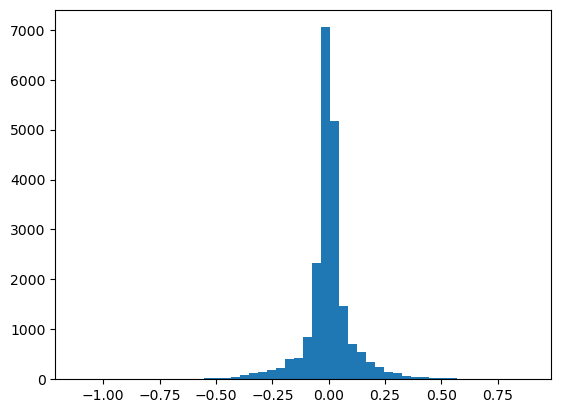

In [32]:
plt.hist(normalized,bins=50)

In [33]:
# i would expect the sound to have 0 mean? this is a Q for JoYo
# next step:
# # filter data? passband the PCG data to 1kHz and resample
# # add the noise to the PCG data (normalize noise first)
# # start to build classifier...
# # can create a stereo track and then combine it to mono?


### 2 - Normalization steps for the data

In [34]:
def lowpass_filter(signal_data, sampling_rate, cutoff_freq=400, order=4):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalize cutoff frequency
    
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

In [35]:
def plot_fourier_spectrum(audio_signal, sample_rate,step_size=10,title='Fourier Spectrum Magnitude'):
    # Compute the FFT
    fft_values = np.fft.fft(audio_signal)
    magnitude = np.abs(fft_values)  # Get magnitude spectrum
    freq = np.fft.fftfreq(len(audio_signal), d=1/sample_rate)  # Frequency axis

    # Keep only the positive frequencies (since this is real valued data)
    half_idx = len(freq) // 2
    freq = freq[:half_idx:step_size] # adding these steps 
    magnitude = magnitude[:half_idx:step_size]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.grid()
    plt.show()

In [36]:
# huge Q at this point. What gets resampled to what frequency? 
# # i suppose we are strictly interested in low-ish frequency noise (everything else
# ... would get nuked. )

Original shape: (278959,), Filtered shape: (278959,), Resampled shape: (12652,)


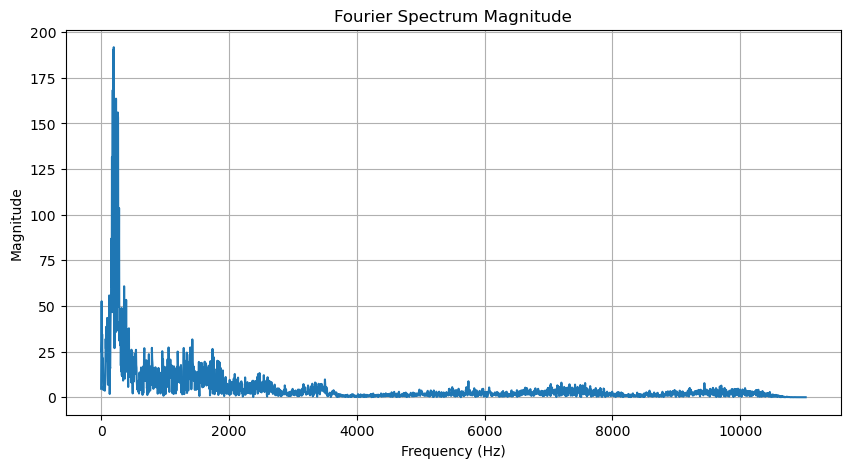

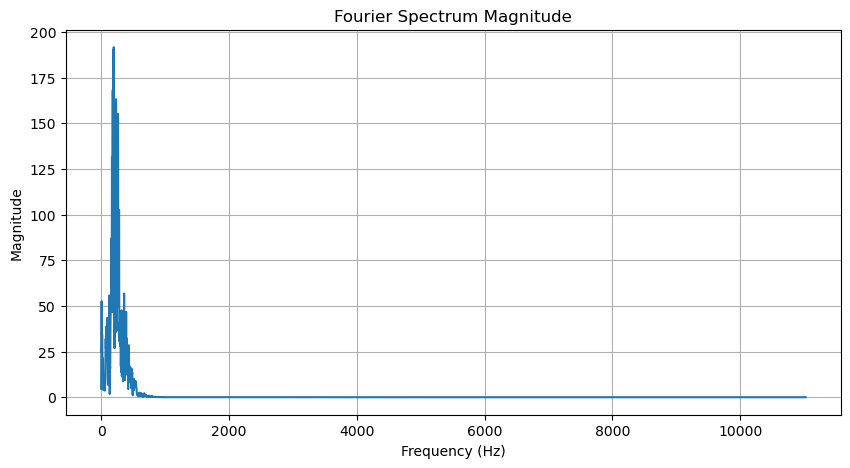

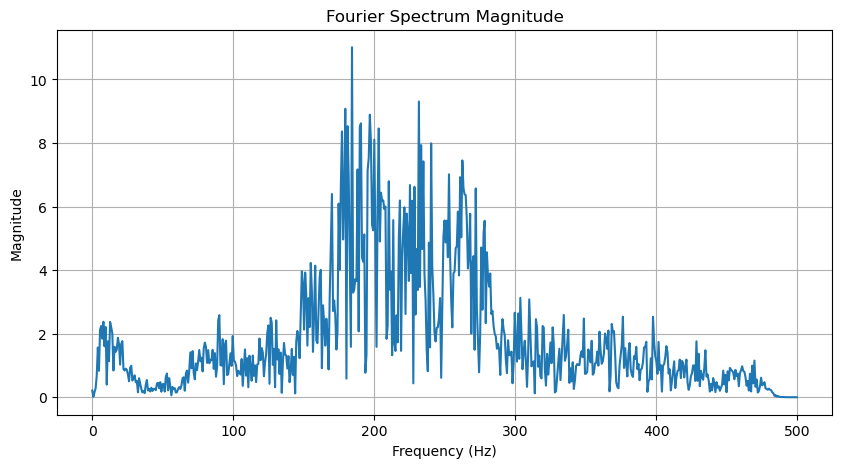

/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/407722.wav


In [37]:
# Test 
cutoff_freq = 500
target_freq = cutoff_freq * 2

for wav in list_of_wavs:
    path_to_wav = arcawavs_path + str(wav) + '.wav'
    audiodata, sr = librosa.load(path_to_wav)

    # Apply low-pass filter
    audio_data_new = lowpass_filter(audiodata, sr, cutoff_freq)

    # Resample the filtered signal
    new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)

    # Debugging info
    print(f"Original shape: {audiodata.shape}, Filtered shape: {audio_data_new.shape}, Resampled shape: {new.shape}")

    # Plot frequency content at each step
    plot_fourier_spectrum(audiodata, sr,step_size=50)  # Original
    plot_fourier_spectrum(audio_data_new, sr,step_size=50)  # After filtering
    plot_fourier_spectrum(new, target_freq,step_size=10)  # After resampling

    print(path_to_wav)
    break  # Stops after first file (as intended)


In [38]:
def load_from_filepath(filepath):
    """
    Load an audio file from a given file path and return the audio data and sample rate.
    """
    audio_data, sample_rate = librosa.load(filepath)
    return audio_data, sample_rate

In [39]:
def downsample(audiodata, sr, target_freq):
  """
  Given a filepath for a wav, downsamples the audio to a target frequency
  (applies an LPF beforehand accordingly)
  """
  audio_data_new = lowpass_filter(audiodata, sr, target_freq//2)
  new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)
  return new

In [40]:
for wav in list_of_wavs:
  path_to_wav = arcawavs_path + str(wav) + '.wav'
  arca_data, arca_sr = load_from_filepath(path_to_wav)
  downsample(arca_data, arca_sr, 2000)

#### Comments
- I think a good enough idea is to LPF everything at 1kHz, then resample to 2kHz 

## 3 - Add noise to the recordings

In [41]:
def get_random_noise_path():
  random_wav = random.choice(list_of_wavs)
  label = noise_data[noise_data['fname'] == random_wav]['label'].values[0]
  print(f'ARCA23K file: {random_wav}. Noise Type: {label}')
  # !impt: there seems to be an enormous rate of mislabelling. terrible dset...
  return arcawavs_path + str(random_wav) + '.wav'

In [65]:
def get_n_random_noise_paths_arca(n):
  return [arcawavs_path + str(x) + '.wav' for x in random.sample(list_of_wavs, n)]

In [71]:
def get_n_random_noise_paths_han(n):
  return [han_filtered_path + x for x in random.sample(os.listdir(han_filtered_path), n)]

In [73]:
get_n_random_noise_paths_arca(5)

['/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/271872.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/504358.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/503920.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/527645.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/242633.wav']

In [75]:
get_n_random_noise_paths_han(5)

['/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-filtered-resampled/seg_217.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-filtered-resampled/seg_304.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-filtered-resampled/seg_322.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-filtered-resampled/seg_167.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-filtered-resampled/seg_229.wav']

In [43]:
noise_data

,fname,label,mid
0,507,Acoustic_guitar,/m/042v_gx
1,251090,Acoustic_guitar,/m/042v_gx
2,161470,Acoustic_guitar,/m/042v_gx
3,18489,Acoustic_guitar,/m/042v_gx
4,251185,Acoustic_guitar,/m/042v_gx
...,...,...,...
17974,463104,Zipper_(clothing),/m/01s0vc
17975,575516,Zipper_(clothing),/m/01s0vc
17976,403656,Zipper_(clothing),/m/01s0vc
17977,562333,Zipper_(clothing),/m/01s0vc


In [44]:
get_random_noise_path() # this does get a random noise

ARCA23K file: 524836. Noise Type: Cough


'/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/524836.wav'

In [45]:
def match_signal_and_noise_lengths(signal, noise):
  """
  Given a signal and noise, makes the noise the same length as signal through:
  - zero padding, or:
  - truncating the noise
  """
  signal_len = len(signal)
  noise_len = len(noise)
  if signal_len > noise_len:
    # Pad the noise with zeros
    noise = np.pad(noise, (0, signal_len - noise_len))
  elif signal_len < noise_len:
    # Truncate the noise
    noise = noise[:signal_len]
  return noise

In [46]:
def create_composite_at_snr(signal,noise, snr_db):
  """
  Function to combile two audio arrays, one signal one noise, at a given SNR
  
  SNR is in dB
  """
  signal_power = np.sum(signal**2)
  noise_power = np.sum(noise**2)
  ratio = np.sqrt((signal_power / noise_power) / (10 ** (snr_db / 10)))
  noise *= ratio
  return signal + noise

In [47]:
def create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq, snr):
  """
  A top-level function that combines the above functions to create a composite sound.
  
  Given a PCG filepath and a noise filepath, creates a composite sound by adding the two together.
  Both files are downsampled to the target frequency.
  
  
  Inputs:
  - pcg_filepath
  - noise_filepath
  - target_freq: the frequency to downsample the pcg data and noise data to
  - snr: desired SNR in dB of the combined sounds
  
  Returns the (downsampled) ground truth PCG data and the composite sound
  """
  pcg = downsample(pcg_raw, pcg_sr, target_freq) # downsample the PCG data
  noise = downsample(noise_raw, noise_sr, target_freq)
  noise = match_signal_and_noise_lengths(pcg, noise) # they are now the same size
  composite = create_composite_at_snr(pcg, noise, snr) # combine the two
  composite = normalize_pm_1(composite, np.max(composite), np.min(composite)) # normalize. I think this is good...
  
  return pcg, composite #composite

ARCA23K file: 81921. Noise Type: Female_speech_and_woman_speaking


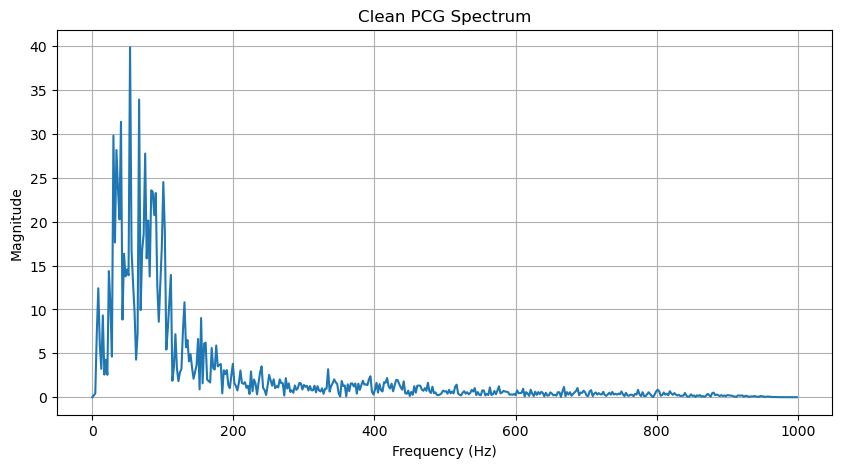

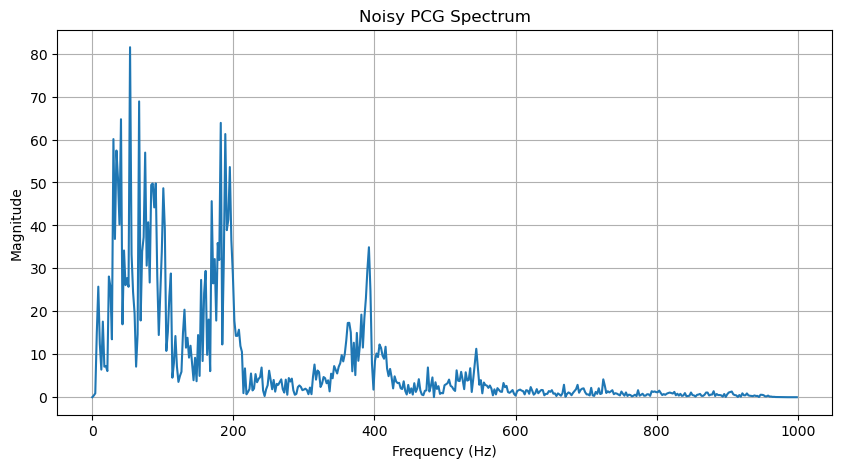

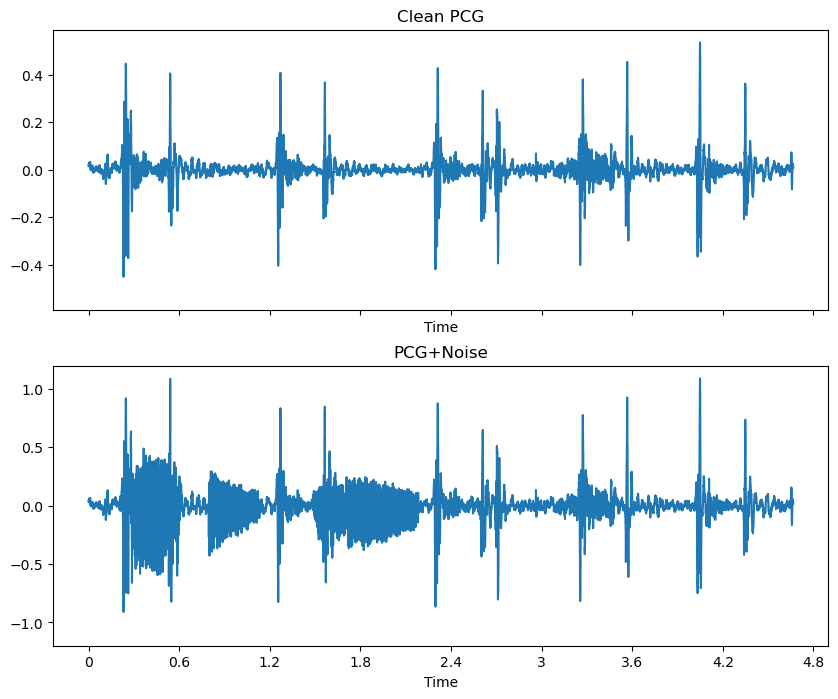

In [85]:
# proof of concept: see the spectrum of a clean PCG and a composite sound
target_freq = 2000 # downsample to this
snr_db = 3
for clean_pcg in pcg_data['fname']:
  if not clean_pcg.endswith('.wav'): # avoid .DS_Store among other things
    continue
  pcg_filepath = pascal_dset_path + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  noise_raw, noise_sr = load_from_filepath(random_noise)
  
  clean, composite = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  # here is where el magico happenso. 
  # look at all the functions you wrote and find a use for them 
  # # e.g. downsample_from_filepath
  
  clean -= np.mean(clean) # DC components shouldn't be useful...?
  composite -= np.mean(composite)
  # now visualize. in frequency:
  plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
  plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')
  # in time
  fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
  ax[0].set(title='Clean PCG')
  ax[1].set(title='PCG+Noise')
  librosa.display.waveshow(clean,sr=target_freq,ax=ax[0])
  librosa.display.waveshow(composite,sr=target_freq,ax=ax[1])
  break

  


In [49]:
#!impt: so, there is often a huge DC component introduced. i am not sure why this is.
# perhaps the NN will learn to discard it, which would be fine. 
# but, it's also a pretty simple thing to discard

# for now i'll get rid of it, but i have some reservations here...

# !impt: this is a pretty naive mechanism of adding noise to the PCG data. if the PCG
# ... is (blessedly) long, then the noise will only occupy a small part of it.

## 4 - Making the STFT features

In [51]:
from scipy.signal import ShortTimeFFT

In [52]:
#ShortTimeFFT()
nperseg = 1024
hann = signal.windows.hann(nperseg)

In [53]:
SFT = ShortTimeFFT(hann, hop=nperseg//4, fs = target_freq)

### 4.a - Creating Inputs and outputs for the model

In [54]:
unique_shapes, unique_shapes_2 = set(), set()

inputs = []
outputs = []

for pcg_local_path in pcg_data['fname']:
  if not pcg_local_path.endswith('.wav'): # avoid .DS_Store among other things
    continue
  if not wav_lengths[pcg_local_path] > CUTOFF_SECONDS:
    continue
  # here we have a problem with the function about "create composite from filepaths"
  pcg_filepath = clean_pcg_locations + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  noise_raw, noise_sr = load_from_filepath(random_noise)
  pcg_raw = pcg_raw[:CUTOFF] # truncate the PCG data, to 2 seconds. 

  clean, composite = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  clean -= np.mean(clean)
  composite -= np.mean(composite)

  # now, stft:
  stft_clean = SFT.stft(clean)
  unique_shapes.add(tuple(stft_clean.shape)) # everything is 513x18
  stft_noisy = SFT.stft(composite)
  unique_shapes_2.add(tuple(stft_noisy.shape)) # everything is 513x18
  
  inputs.append(stft_noisy[2])
  outputs.append(stft_clean[2])
print(unique_shapes,unique_shapes_2)

ARCA23K file: 508598. Noise Type: Crumpling_and_crinkling
ARCA23K file: 169813. Noise Type: Cough
ARCA23K file: 444742. Noise Type: Crumpling_and_crinkling
ARCA23K file: 458375. Noise Type: Crumpling_and_crinkling
ARCA23K file: 536465. Noise Type: Crumpling_and_crinkling
ARCA23K file: 74439. Noise Type: Child_speech_and_kid_speaking
ARCA23K file: 177286. Noise Type: Cough
ARCA23K file: 458376. Noise Type: Crumpling_and_crinkling
ARCA23K file: 469376. Noise Type: Child_speech_and_kid_speaking
ARCA23K file: 315829. Noise Type: Child_speech_and_kid_speaking
ARCA23K file: 508597. Noise Type: Crumpling_and_crinkling
ARCA23K file: 169813. Noise Type: Cough
ARCA23K file: 566933. Noise Type: Cough
ARCA23K file: 566934. Noise Type: Cough
ARCA23K file: 355063. Noise Type: Crumpling_and_crinkling
ARCA23K file: 216109. Noise Type: Crumpling_and_crinkling
ARCA23K file: 447396. Noise Type: Crumpling_and_crinkling
ARCA23K file: 572188. Noise Type: Child_speech_and_kid_speaking
ARCA23K file: 491399. N

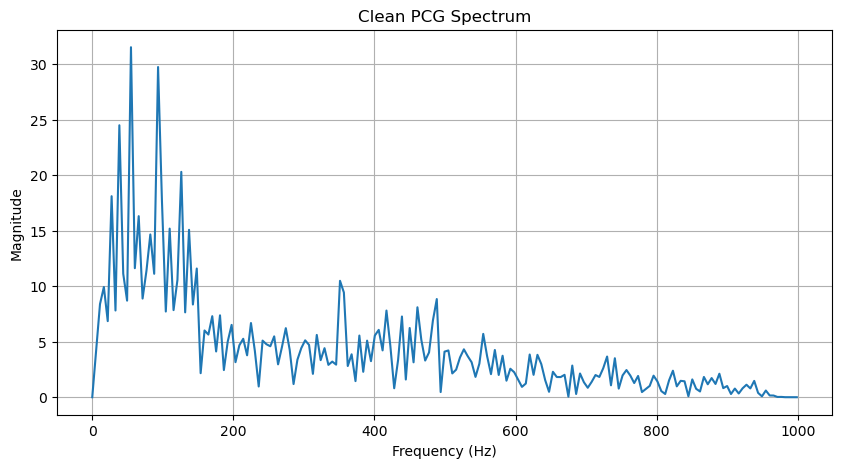

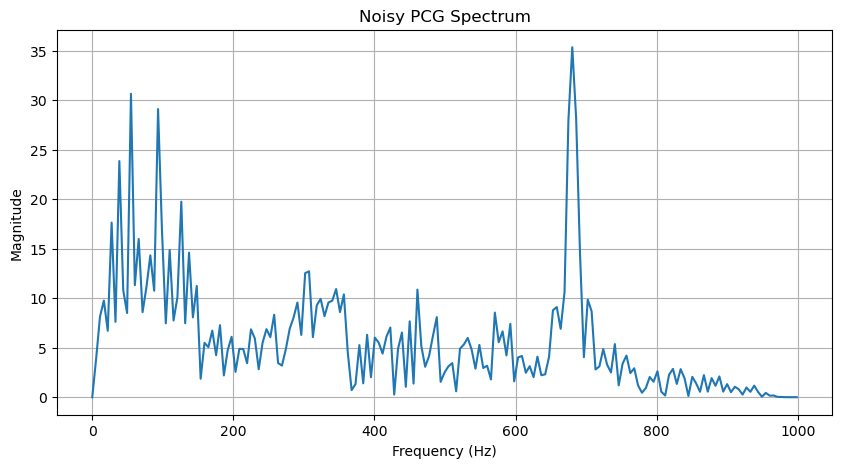

In [55]:
  plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
  plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')

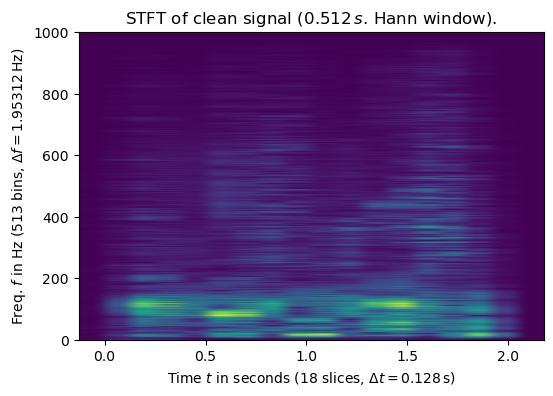

In [56]:
fig1, ax1 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax1.set_title(rf"STFT of clean signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(stft_clean), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

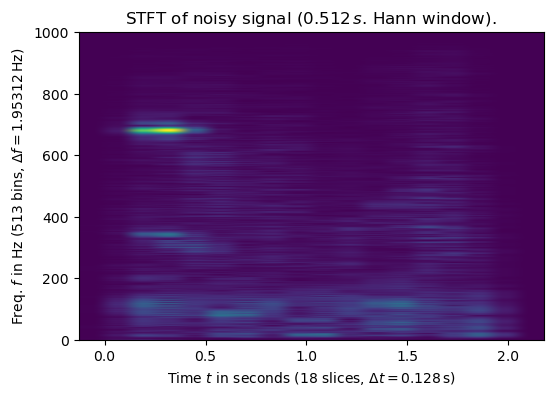

In [57]:
fig2, ax2 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax2.set_title(rf"STFT of noisy signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax2.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im2 = ax2.imshow(abs(stft_noisy), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

In [58]:
stft_noisy # this is complex. should the real and imag parts be split?

array([[ 1.94407720e-01+0.00000000e+00j,  1.53934448e+00+0.00000000e+00j,
         2.52097394e+00+0.00000000e+00j, ...,
        -4.94835997e-01+0.00000000e+00j,  3.61907266e-02+0.00000000e+00j,
        -3.59743006e-02+0.00000000e+00j],
       [-1.06685233e-01-1.50162258e-01j,  6.79736929e-01-1.12546255e+00j,
         1.87944895e+00+1.51275177e-01j, ...,
        -2.24393103e-01-7.03830596e-01j,  6.28970497e-02+1.82307839e-01j,
         3.43613950e-02-1.06305385e-02j],
       [-5.31371374e-02+1.47736953e-01j, -2.24537926e-01-8.78044607e-01j,
         5.90242819e-01+2.87158157e-01j, ...,
         7.07563856e-01-1.47819925e+00j, -6.07113821e-01+7.37783111e-02j,
        -2.96749385e-02+2.02903792e-02j],
       ...,
       [ 3.48619892e-04-3.67875679e-05j, -6.75356815e-04+7.43372560e-05j,
         3.09202534e-04-3.66588011e-05j, ...,
        -3.86716171e-04-1.34746580e-04j,  2.34718987e-04+5.93773869e-05j,
        -4.55442877e-06+8.93431323e-06j],
       [-1.88228363e-05-3.47319344e-04j, -6.

In [84]:
# !impt: do i have enough data? So far, 200-some noisy samples...
# ways to get more data:
# # add multiple noise copies to each PCG sample

## 5 - Making Training and Test Data

### 5.a - Adding arbitrary noise 

In [50]:
# Some things to do:
# # From the ~250 clean recordings, add like 10 pairs of noise each
# # The noise can be from the ARCA23K dataset, but also the HAN dataset

In [86]:
target_freq = 2000 # downsample to this
snr_db = [-3,0,3,6]
seconds_per_segment = 0.8
segment_length = int(target_freq*seconds_per_segment)

# inputs and outputs for the model. Inputs are noisy, outputs are ground truth 
# takes a minute by the way
inputs = []
outputs = []
for clean_pcg in pcg_data['fname']: # contains murmurs and normal PCG data
  if not clean_pcg.endswith('.wav'): # avoid .DS_Store among other things
    continue
  signal_filepath = pascal_dset_path + clean_pcg
  signal_raw, signal_sr = load_from_filepath(signal_filepath)
  # do not truncate yet.
  for snr in snr_db:
    for noise_path in get_n_random_noise_paths_han(4):
      noise_raw, noise_sr = load_from_filepath(noise_path)
      clean, composite = create_composite(signal_raw, signal_sr, noise_raw, noise_sr, target_freq, snr)

      for i in range(0,len(clean)//segment_length):
        clean_subsection = clean[i*segment_length:(i+1)*segment_length]
        composite_subsection = composite[i*segment_length:(i+1)*segment_length]
        # remove DC component (should this be done at subsection level though?)
        clean_subsection -= np.mean(clean_subsection)
        composite_subsection -= np.mean(composite_subsection)
        
        inputs.append(composite_subsection)
        outputs.append(clean_subsection)

    for noise_path in get_n_random_noise_paths_arca(3):
      noise_raw, noise_sr = load_from_filepath(noise_path)
      clean, composite = create_composite(signal_raw, signal_sr, noise_raw, noise_sr, target_freq, snr)
      
      for i in range(0,len(clean)//segment_length):
        clean_subsection = clean[i*segment_length:(i+1)*segment_length]
        composite_subsection = composite[i*segment_length:(i+1)*segment_length]
        # remove DC component (should this be done at subsection level though?)
        clean_subsection -= np.mean(clean_subsection)
        composite_subsection -= np.mean(composite_subsection)
        
        inputs.append(composite_subsection)
        outputs.append(clean_subsection)

/var/folders/c9/h_6qs3ld1mb00yp5yqn2w11c0000gn/T/ipykernel_13183/1104573914.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = np.sqrt((signal_power / noise_power) / (10 ** (snr_db / 10)))
/var/folders/c9/h_6qs3ld1mb00yp5yqn2w11c0000gn/T/ipykernel_13183/1104573914.py:10: RuntimeWarning: invalid value encountered in multiply
  noise *= ratio


In [91]:
# got a scary warning about divide by zero. Since this is stochastic ig i could just run it again though.

{1600}


In [79]:
print(len(os.listdir(clean_pcg_locations)))

648


## 6 - U-Net Architecture

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F